### Predicting the number of problems per km2

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score 

import shap

In [2]:
SMALL_SIZE = 8 # points
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams['figure.facecolor']   = 'white'
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.facecolor']     = 'white'
plt.rcParams['axes.spines.right']  = False
plt.rcParams['axes.spines.top']    = False
plt.rcParams['font.family']        = 'sans-serif'
plt.rcParams['font.sans-serif']    = ['Arial', 'DejaVu']
plt.rcParams['savefig.dpi']        = 300
plt.rcParams['svg.fonttype']       = 'none'
plt.rcParams['pdf.fonttype']       = 42
plt.rcParams['ps.fonttype']        = 42

cm = 1/2.54  # centimeters in inches
single_col = 8.9*cm
oneDot5_col = 12.7*cm
two_col = 18.2*cm

In [3]:
input_folder  = './processed_db'
output_folder = './files_ML_problemsPerKm2'

In [4]:
df = pd.read_csv('{}/db_criminalBehaviour_TimeRegional.csv'.format(input_folder))
df.drop(['categories', 'Unnamed: 0'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               4369 non-null   int64  
 1   regional_name      4369 non-null   object 
 2   problem_type_1     4369 non-null   object 
 3   count              4369 non-null   int64  
 4   nProb_km2          4317 non-null   float64
 5   avg_monthlyIncome  4317 non-null   float64
 6   pop_km2            4317 non-null   float64
 7   people_house       4317 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 273.2+ KB


In [5]:
df.dropna(how='any', inplace=True)

In [6]:
df.describe()

,time,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,12.792448,20.851054,0.551123,1439.989576,4058.527913,3.310892
std,6.456456,58.770645,1.629594,725.830531,1523.685147,0.564748
min,0.000000,1.000000,0.015601,518.000000,1126.000000,2.580000
25%,8.000000,1.000000,0.028329,870.000000,2775.000000,2.770000
50%,13.000000,4.000000,0.100503,1384.000000,3942.000000,3.420000
75%,18.000000,19.000000,0.468019,1612.000000,5573.000000,3.630000
max,23.000000,1283.000000,35.344353,2897.000000,6193.000000,4.550000


In [7]:
df.problem_type_1.unique()

array(['Agression', 'Break-in', 'Corporal injury', 'Environmental crime',
       'Gang-sacking/pillaging', 'Gunshot', 'Illegal possession',
       'Illitcit Substance', 'Kidnapping and imprisonment', 'Murder',
       'Non-compliance with law 15799/2021 COVID-19',
       'Obscene/libelous acts', 'Physical/Verbal Agression', 'Racism',
       'Robbery', 'Theft',
       'Violation of Protective Measures for women - Lei Maria da Penha',
       'Fishing in Prohibited Places', 'Maltreatment', 'Rape',
       'Sexual harassment',
       'Abandonment/nonsupport of incompetent person',
       'Crime against individual liberty', 'Embezzlement', 'Homophobia',
       'Prohibited sale of specific products to minors',
       'Possession of explosive device', 'False Identity',
       'Fraud (monetary)', 'Impersonating a public official',
       'Violation of graves', 'Animal abuse', 'Misuse of transport card',
       'Child grooming/enticement', 'Omission of assistance',
       'False money', 'Abuse of

In [8]:
problems2keep = [
    'Agression', 'Corporal injury', 
       'Gunshot', 'Robbery', 'Theft',
       'Kidnapping and imprisonment', 'Murder',
       'Physical/Verbal Agression', 
       'Maltreatment', 'Rape',
       'Sexual harassment',
       'Sexual assault/rape', 
]

In [9]:
df = df[df['problem_type_1'].isin(problems2keep)]
df.reset_index(inplace=True)
df.drop('index', axis=1,inplace=True)

Dataframe not modified from here 

In [9]:
df

,time,regional_name,problem_type_1,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house
0,0,BAIRRO NOVO,Agression,9,0.200893,870.0,2775.0,2.65
1,0,BAIRRO NOVO,Corporal injury,13,0.290179,870.0,2775.0,2.65
2,0,BAIRRO NOVO,Gunshot,10,0.223214,870.0,2775.0,2.65
3,0,BAIRRO NOVO,Kidnapping and imprisonment,1,0.022321,870.0,2775.0,2.65
4,0,BAIRRO NOVO,Murder,2,0.044643,870.0,2775.0,2.65
...,...,...,...,...,...,...,...,...
1803,23,TATUQUARA,Gunshot,2,0.048780,518.0,1126.0,3.81
1804,23,TATUQUARA,Maltreatment,1,0.024390,518.0,1126.0,3.81
1805,23,TATUQUARA,Physical/Verbal Agression,18,0.439024,518.0,1126.0,3.81
1806,23,TATUQUARA,Robbery,5,0.121951,518.0,1126.0,3.81


Plots

In [63]:
num_features = ['time','nProb_km2','avg_monthlyIncome','pop_km2','people_house']

In [64]:
df[num_features].corr('pearson')

,time,nProb_km2,avg_monthlyIncome,pop_km2,people_house
time,1.000000,0.152301,-0.005943,-0.004189,0.000884
nProb_km2,0.152301,1.000000,0.286005,0.239461,-0.199698
avg_monthlyIncome,-0.005943,0.286005,1.000000,0.559701,-0.193366
pop_km2,-0.004189,0.239461,0.559701,1.000000,-0.004845
people_house,0.000884,-0.199698,-0.193366,-0.004845,1.000000


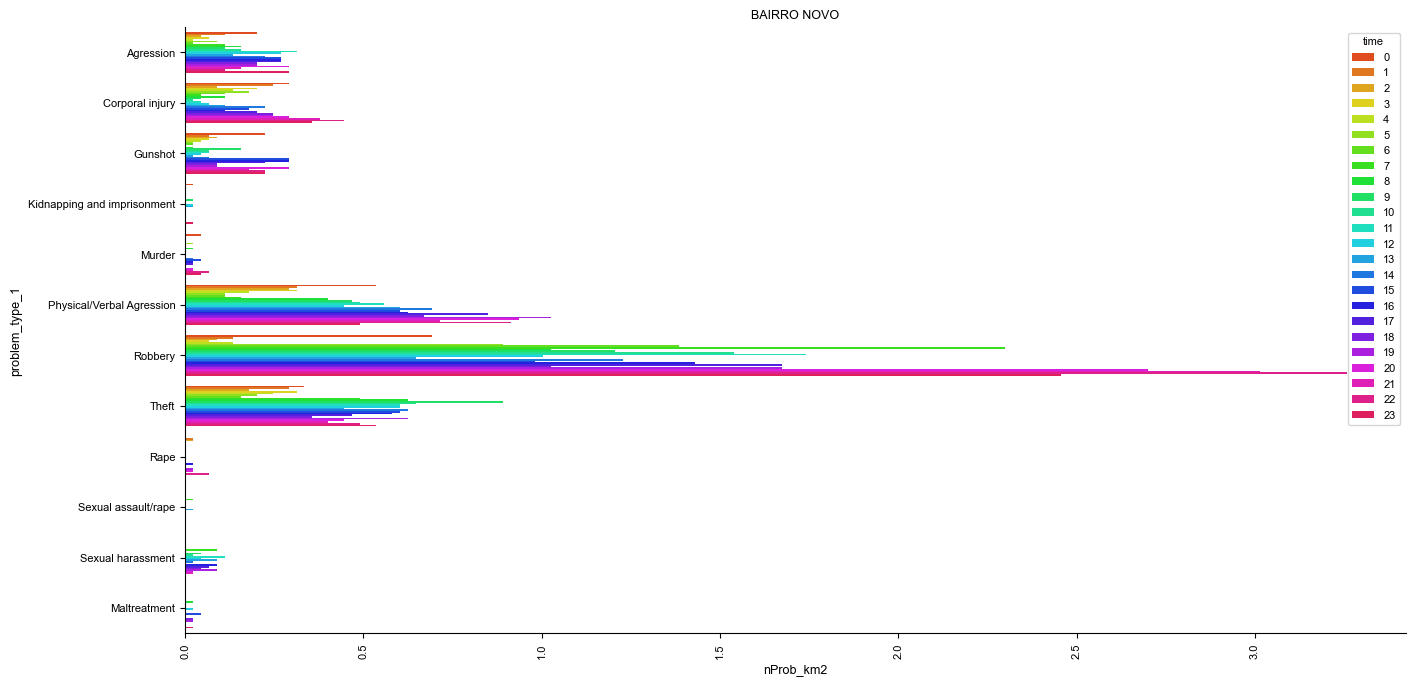

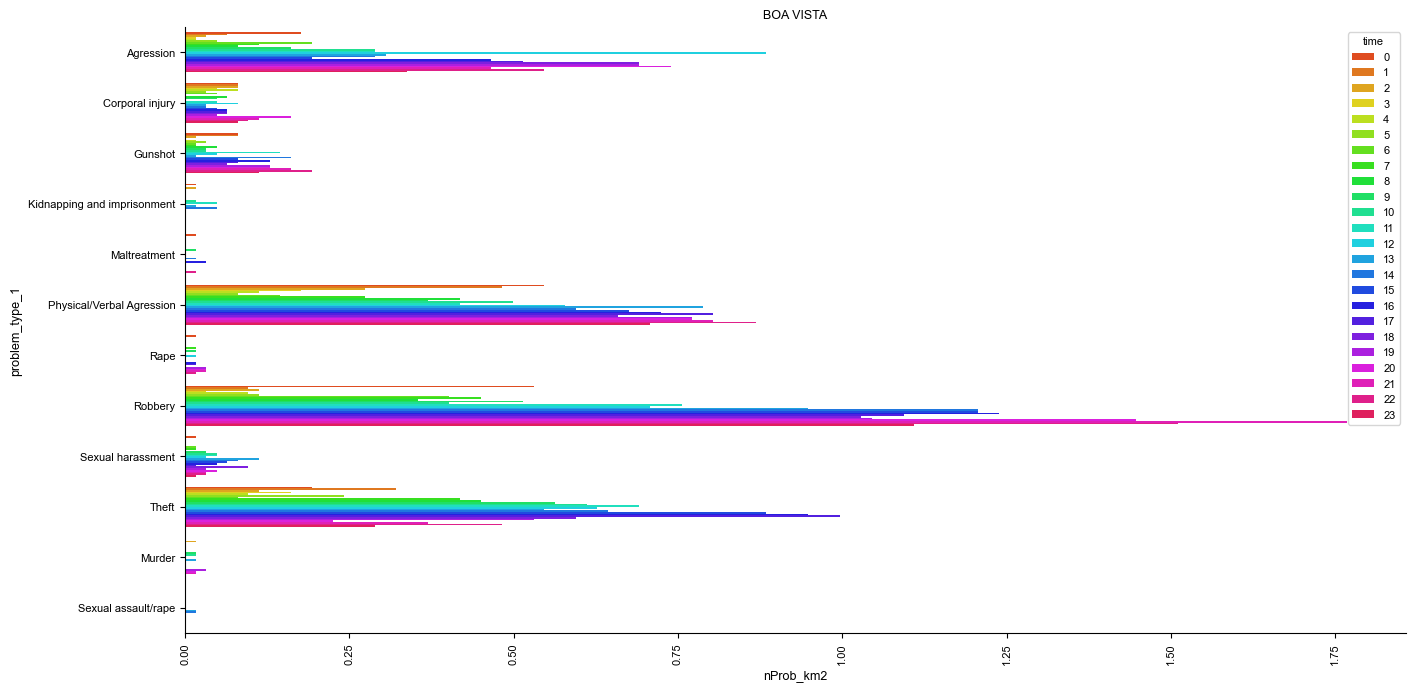

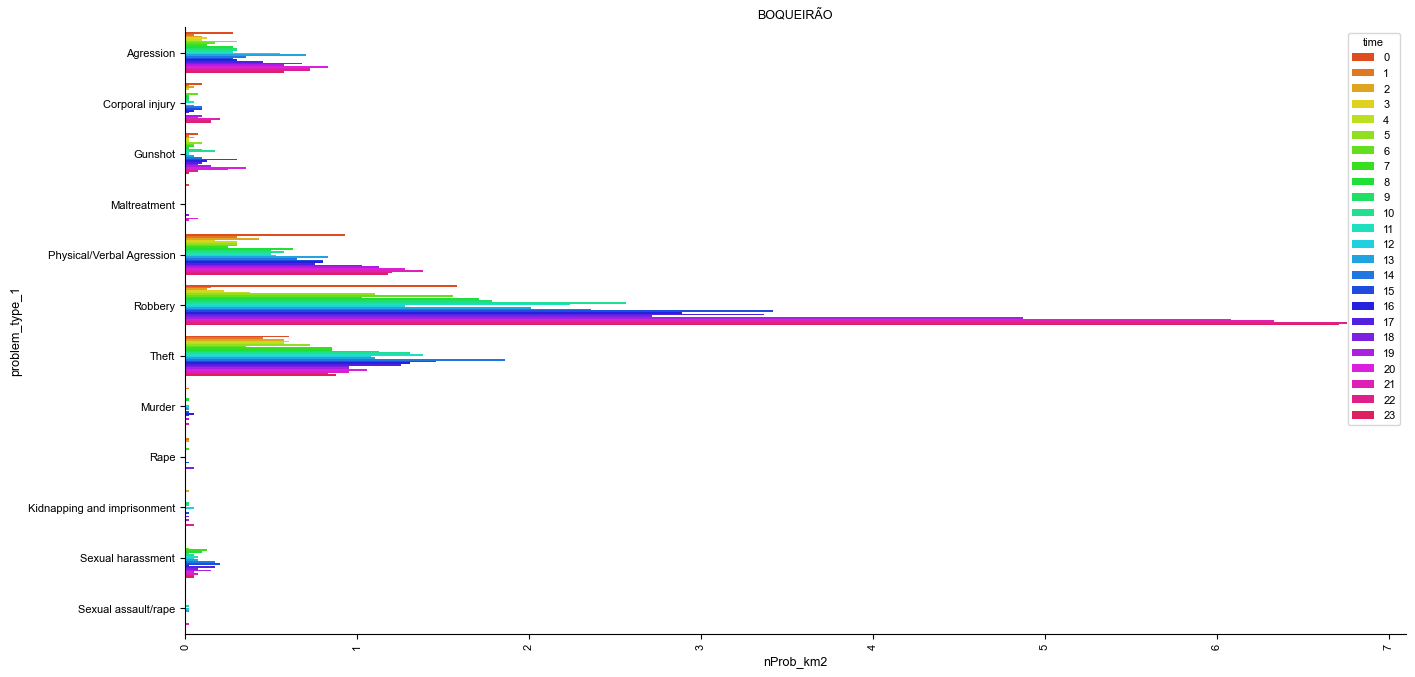

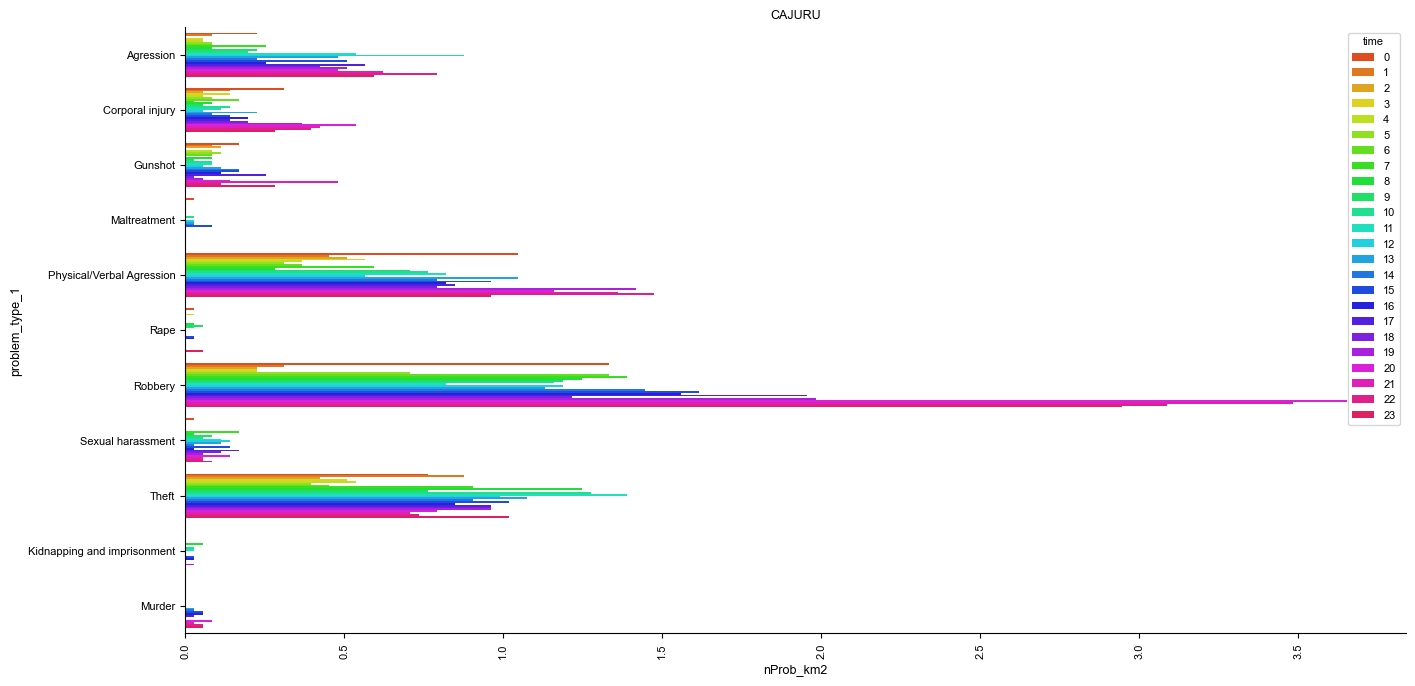

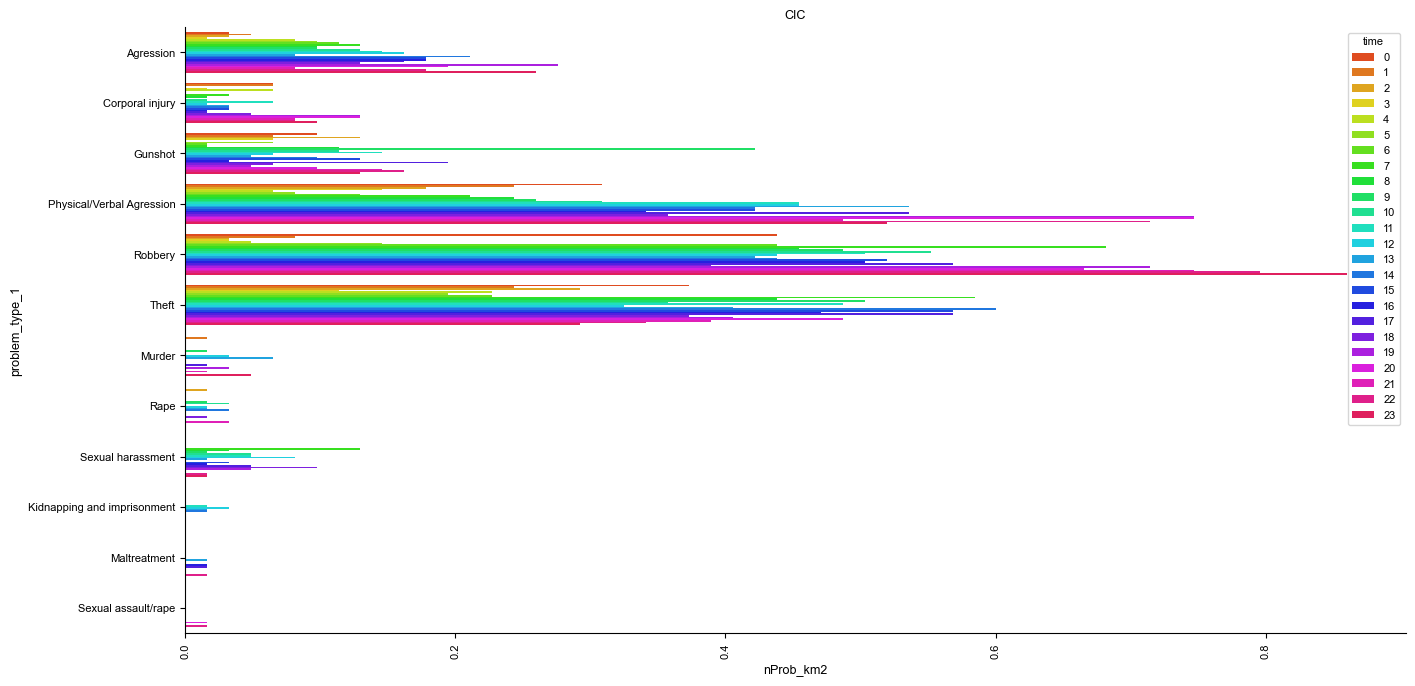

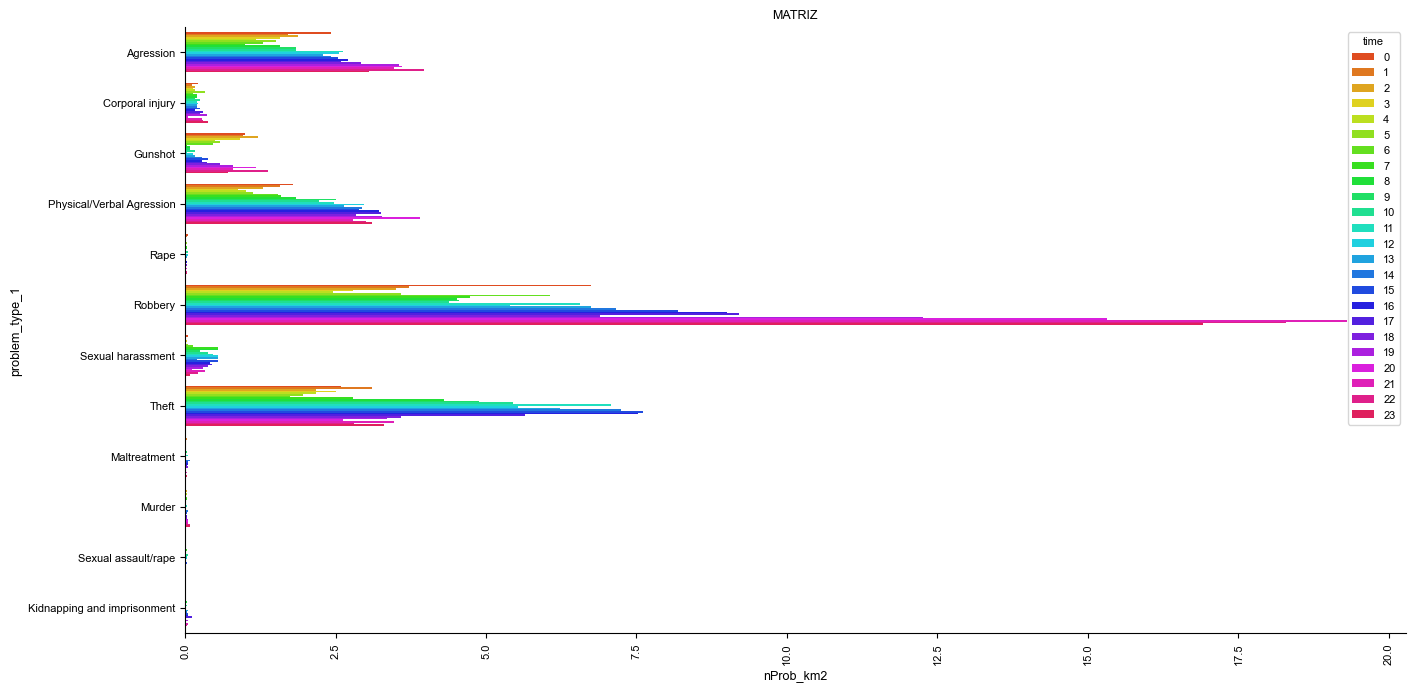

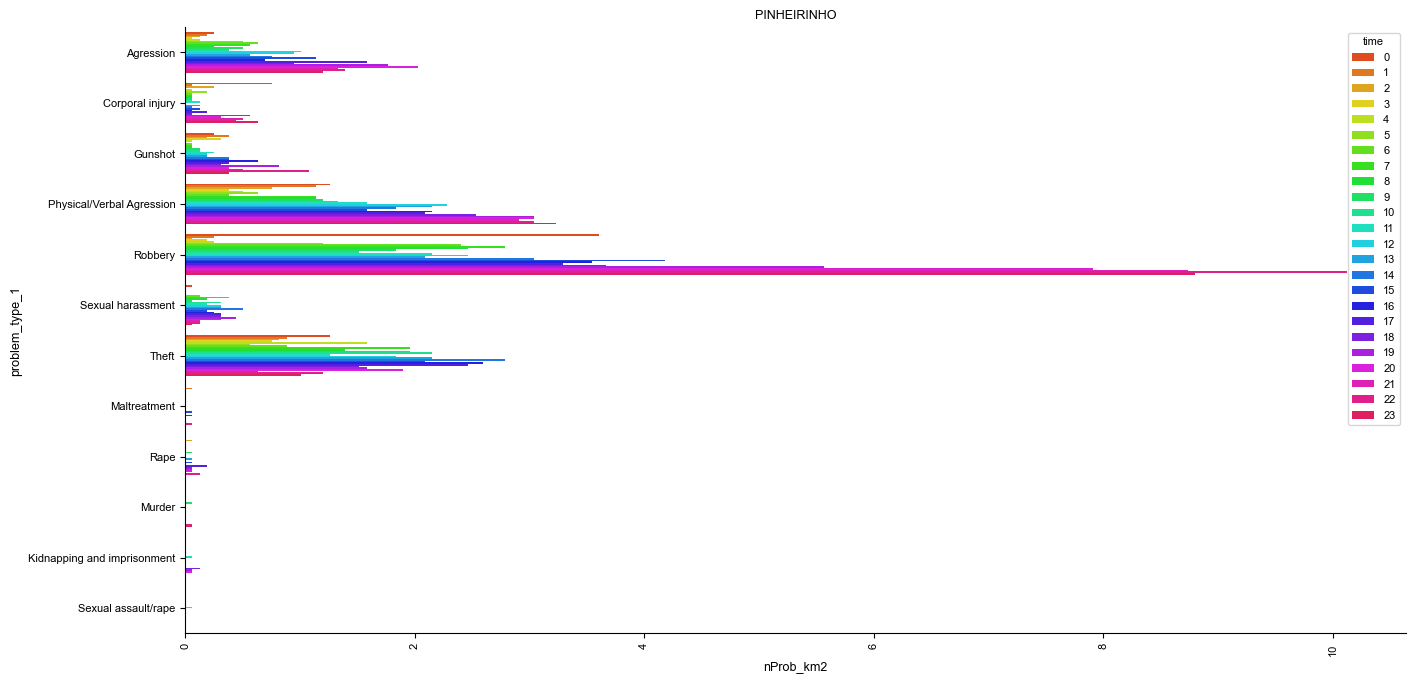

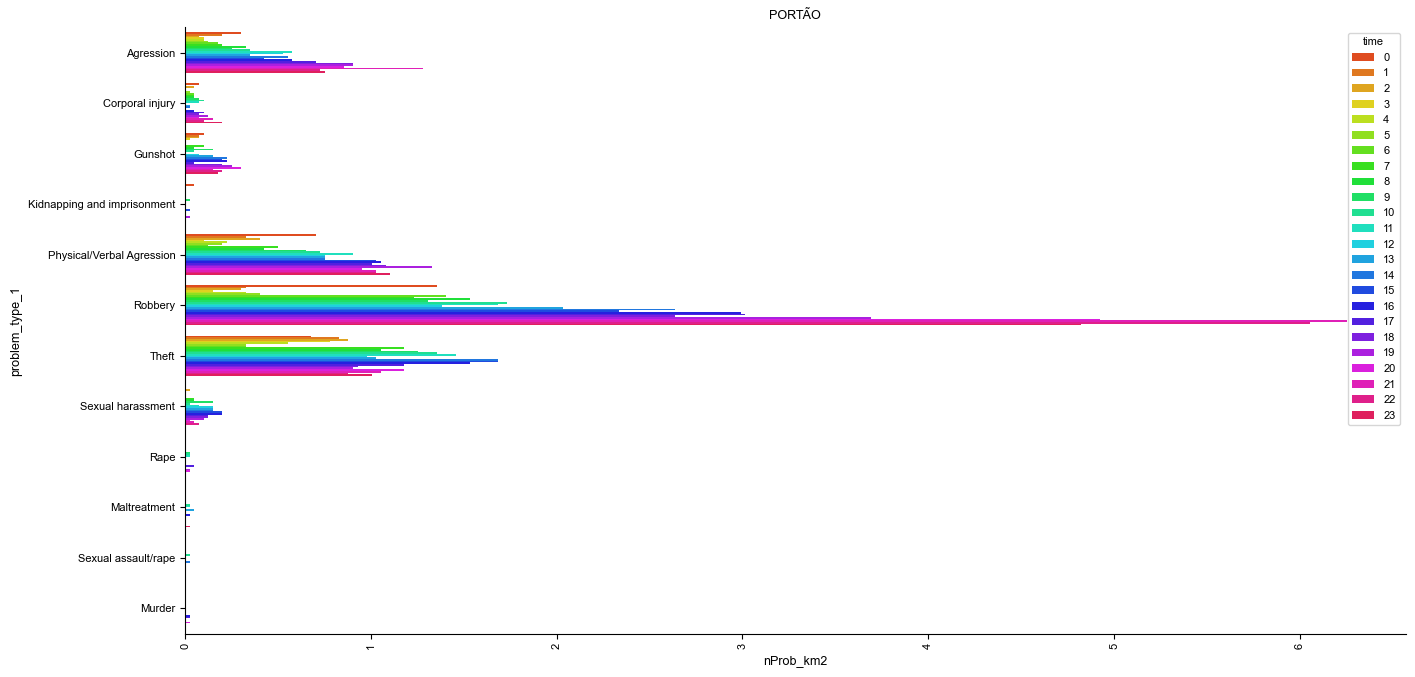

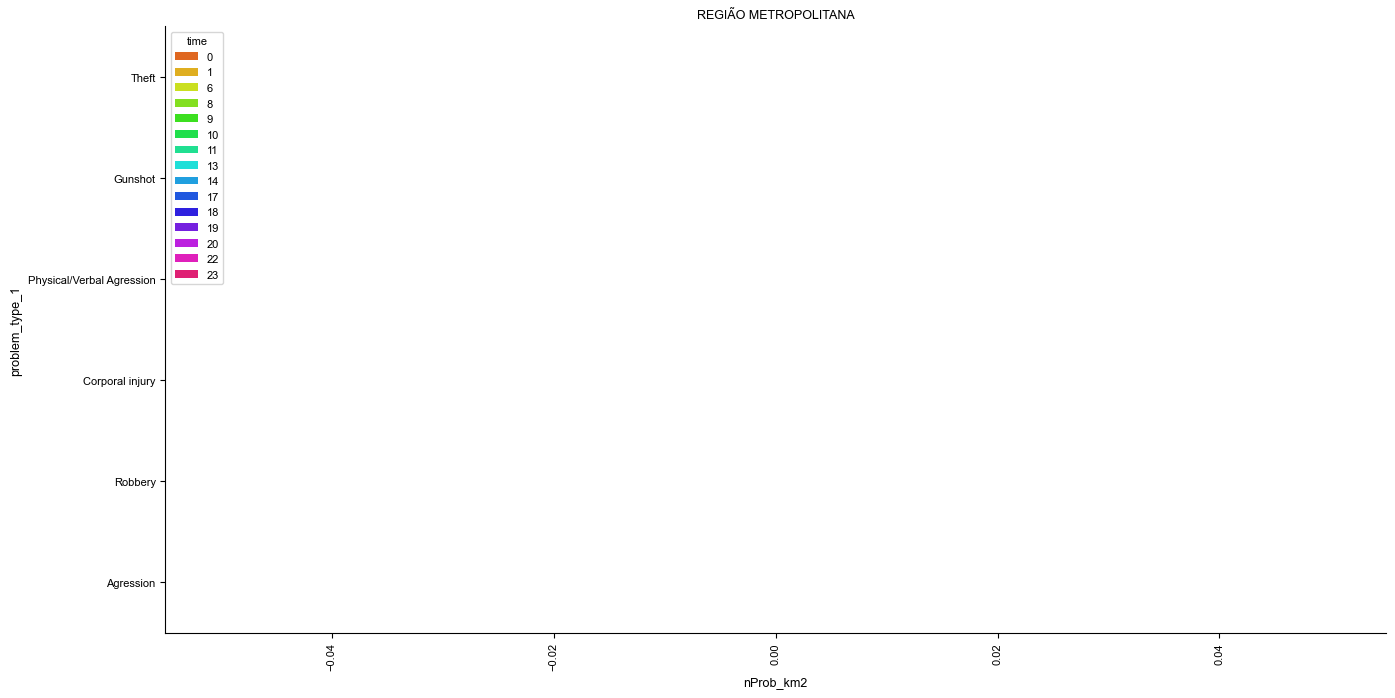

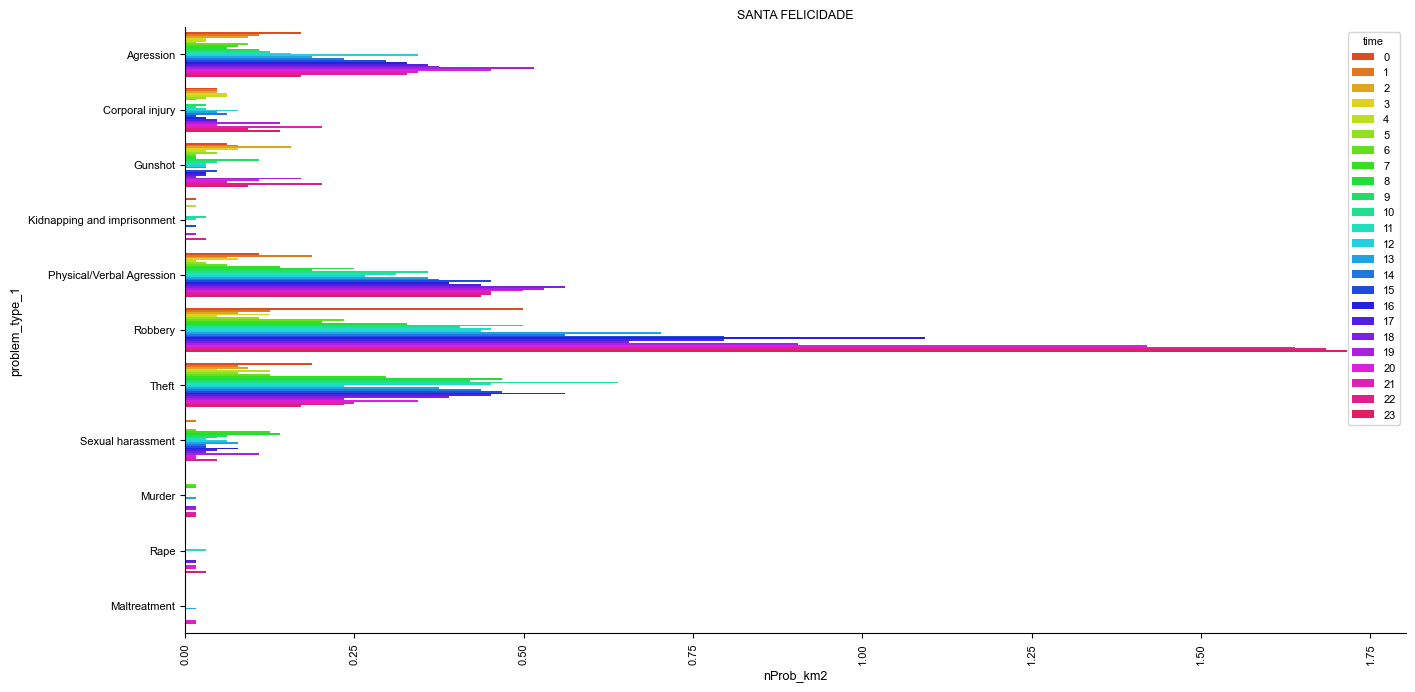

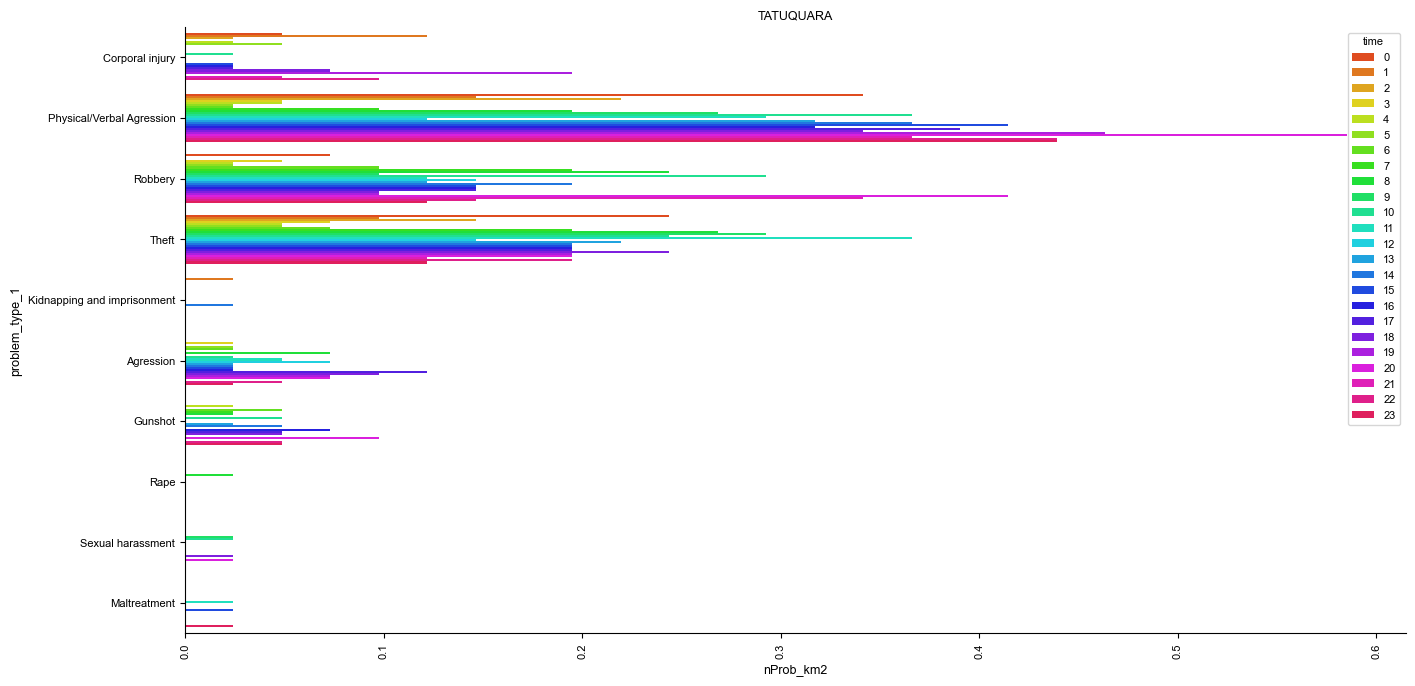

In [21]:
for reg in df.regional_name.unique():
    dt2plot = df[df['regional_name']==reg]
    plt.figure(figsize=(30*cm, 15*cm))
    sns.barplot(data=dt2plot, x='nProb_km2', y='problem_type_1', hue='time', orient='h', palette='hsv')
    plt.title(reg)
    plt.xticks(rotation=90)

c:\Users\vanes\.conda\envs\courseML_phd2023\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\vanes\.conda\envs\courseML_phd2023\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<Axes: xlabel='nProb_km2', ylabel='problem_type_1'>

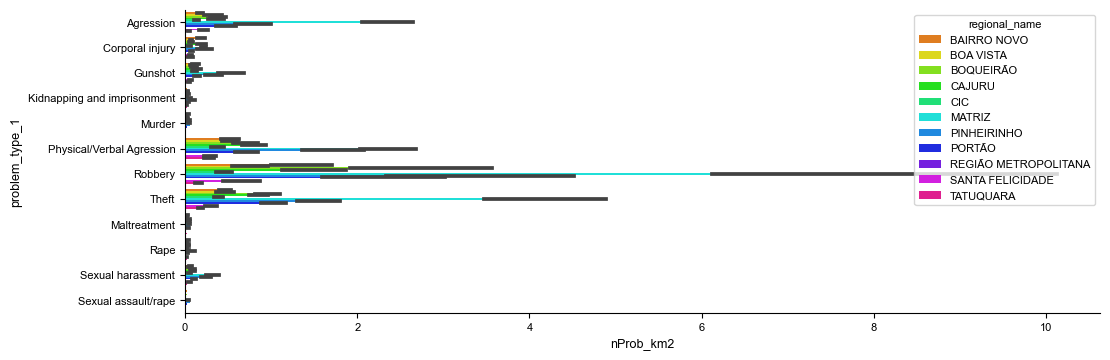

In [23]:
plt.figure(figsize=(30*cm, 10*cm))
sns.barplot(data=df, x='nProb_km2', y='problem_type_1', hue='regional_name', orient='h', palette='hsv')

<Axes: xlabel='time', ylabel='nProb_km2'>

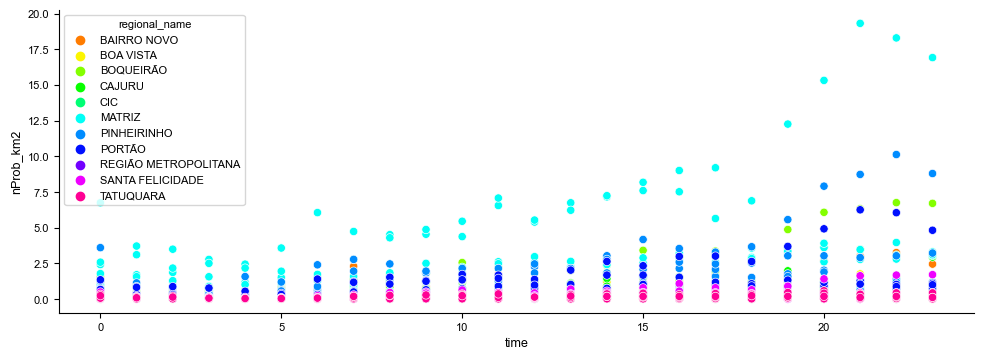

In [25]:
plt.figure(figsize=(30*cm, 10*cm))
sns.scatterplot(data=df, y='nProb_km2', x='time', hue='regional_name', palette='hsv')

<Axes: xlabel='people_house', ylabel='nProb_km2'>

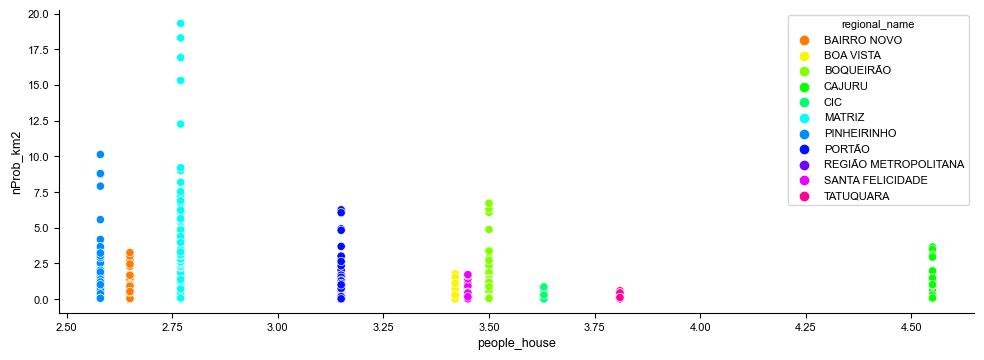

In [26]:
plt.figure(figsize=(30*cm, 10*cm))
sns.scatterplot(data=df, y='nProb_km2', x='people_house', hue='regional_name', palette='hsv')

Defining a test set:

In [10]:
y = np.array(list(df.nProb_km2))
X = df.drop(['count', 'nProb_km2', 'regional_name'], axis=1)

In [11]:
y

array([0.20089286, 0.29017858, 0.22321429, ..., 0.43902439, 0.12195122,
       0.12195122])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dummy Regressor for baseline comparison:

In [20]:
dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred = dummy_regr.predict(y_test)
dummy_regr.score(X_train, y_train)

0.0

In [21]:
r2_score(y_test,y_pred)

-0.0008652403328632818

Well, any model is going to be better than this...

Creating a pipeline and doing the grid-search for a list of selected models:

In [13]:
num_features = ['time', 'avg_monthlyIncome', 'pop_km2', 'people_house']
# cat_features = ['regional_name', 'problem_type_1']
cat_features = ['problem_type_1']

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [15]:
models2test = {
    'SVR' : SVR(),   
    'DTree': DecisionTreeRegressor(random_state=4392),
    'ExtraTree': ExtraTreesRegressor(random_state=4392),
    'GradBoost': GradientBoostingRegressor(random_state=4392),
}

In [36]:
param2test = {
    'SVR' : {
        'classifier__C': [0.1, 1, 10, 100], 
        'classifier__kernel': ['rbf', 'poly', 'sigmoid']
    },   
    'DTree': {
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    },
    'ExtraTree': {
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    },
    'GradBoost': {
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]
    },
}

In [39]:
search = dict()
for clf in models2test.keys():
    print(clf)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models2test[clf])
    ])
    param_grid = param2test[clf]
    search = GridSearchCV(pipeline, param_grid, cv=10).fit(X_train,y_train)
    joblib.dump(search, '{}/paramTuning_{}.pkl'.format(output_folder, clf))

GradBoost


Loading grid search results

In [17]:
bestParams = dict()
bestScores = dict()
bestModels  = dict()
for clf in models2test.keys():
    tmp_load = joblib.load('{}/paramTuning_{}.pkl'.format(output_folder, clf))
    bestParams[clf] = tmp_load.best_params_
    bestScores[clf] = tmp_load.best_score_
    bestModels[clf] = tmp_load.best_estimator_

In [44]:
bestParams

{'SVR': {'classifier__C': 100, 'classifier__kernel': 'rbf'},
 'DTree': {'classifier__criterion': 'squared_error',
  'classifier__max_depth': 8},
 'ExtraTree': {'classifier__criterion': 'absolute_error',
  'classifier__max_depth': 12,
  'classifier__n_estimators': 500},
 'GradBoost': {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 4,
  'classifier__n_estimators': 500}}

In [45]:
bestScores

{'SVR': 0.9244773152025937,
 'DTree': 0.9210988947369696,
 'ExtraTree': 0.9497625370594458,
 'GradBoost': 0.9542072775885085}

In [46]:
bestModels

{'SVR': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer(n_neighbors=4)),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['time', 'avg_monthlyIncome',
                                                    'pop_km2', 'people_house']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(fill_value='missing',
                                                                                  strategy='constant')),
                                                   

In [51]:
scores = dict()
y_pred = dict()

for clf in models2test.keys():
    print(clf)
    
    scores[clf] = cross_validate(bestModels[clf], X_train, y_train, cv=10,
                                scoring=('neg_root_mean_squared_error'),
                                return_train_score=True, return_estimator=False, return_indices=False) 
    y_pred[clf] = cross_val_predict(bestModels[clf], X_train, y_train, cv=10)

SVR
DTree
ExtraTree
GradBoost


In [57]:
for clf in models2test.keys():
    print('-----------------------------------')
    print(clf)
    print('-----------------------------------')
    print('train_rmse mean:  %.4f' % scores[clf]['train_score'].mean())
    print('train_rmse std:  %.4f' % scores[clf]['train_score'].std())
    print('test_rmse mean:  %.4f' % scores[clf]['test_score'].mean())
    print('test_rmse std:  %.4f' % scores[clf]['test_score'].std())
    print('\n')

-----------------------------------
SVR
-----------------------------------
train_rmse mean:  -0.2735
train_rmse std:  0.0107
test_rmse mean:  -0.3453
test_rmse std:  0.1118


-----------------------------------
DTree
-----------------------------------
train_rmse mean:  -0.1276
train_rmse std:  0.0082
test_rmse mean:  -0.3519
test_rmse std:  0.0930


-----------------------------------
ExtraTree
-----------------------------------
train_rmse mean:  -0.0451
train_rmse std:  0.0018
test_rmse mean:  -0.2764
test_rmse std:  0.0806


-----------------------------------
GradBoost
-----------------------------------
train_rmse mean:  -0.0953
train_rmse std:  0.0027
test_rmse mean:  -0.2649
test_rmse std:  0.0759




- ExtraTree seems to be overfitting (has the deepest trees and big difference between train and test scores)
- Same could be said for the decisionTree and the GradientBoosting...

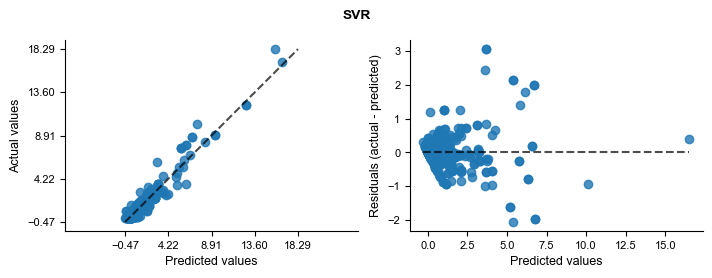

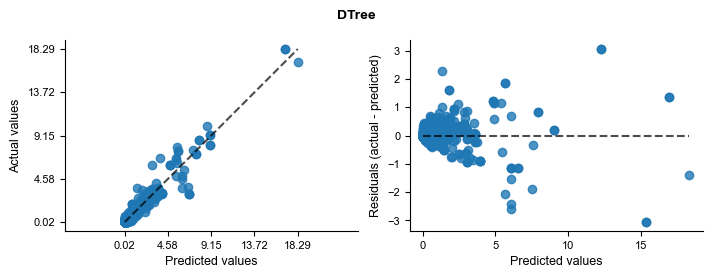

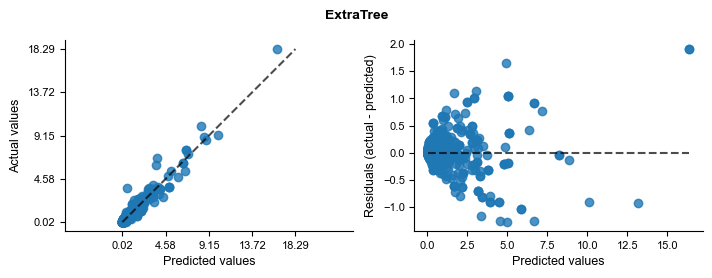

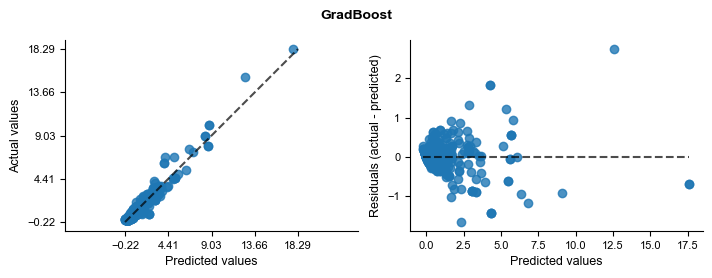

In [55]:
for clf in models2test.keys():
    fig, axs = plt.subplots(ncols=2, figsize=(two_col,7*cm))
    plt.suptitle(clf)
    PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=y_pred[clf],
                                        kind="actual_vs_predicted", ax=axs[0])
    PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=y_pred[clf],
                                        kind="residual_vs_predicted", ax=axs[1])
    plt.tight_layout()

Visually, there's not much of a difference between the model predictions and residuals

Let's check the feature importance for the SVR using the SHAP lib

In [18]:
preproc = preprocessor.fit(X_train)
X_train_pr = preproc.transform(X_train)
X_test_pr  = preproc.transform(X_test)

In [33]:
feat_names = preproc.get_feature_names_out()
feat_names = [x.split('__')[1] for x in feat_names]

In [25]:
X_train_pr = pd.DataFrame(X_train_pr, columns=feat_names)
X_test_pr  = pd.DataFrame(X_test_pr, columns=feat_names)

In [19]:
shap.initjs()

In [35]:
X_train_summary = shap.kmeans(X_train_pr, 10)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [27]:
ex = shap.KernelExplainer(bestModels['SVR'][-1].predict, X_train_summary)

  0%|          | 0/362 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


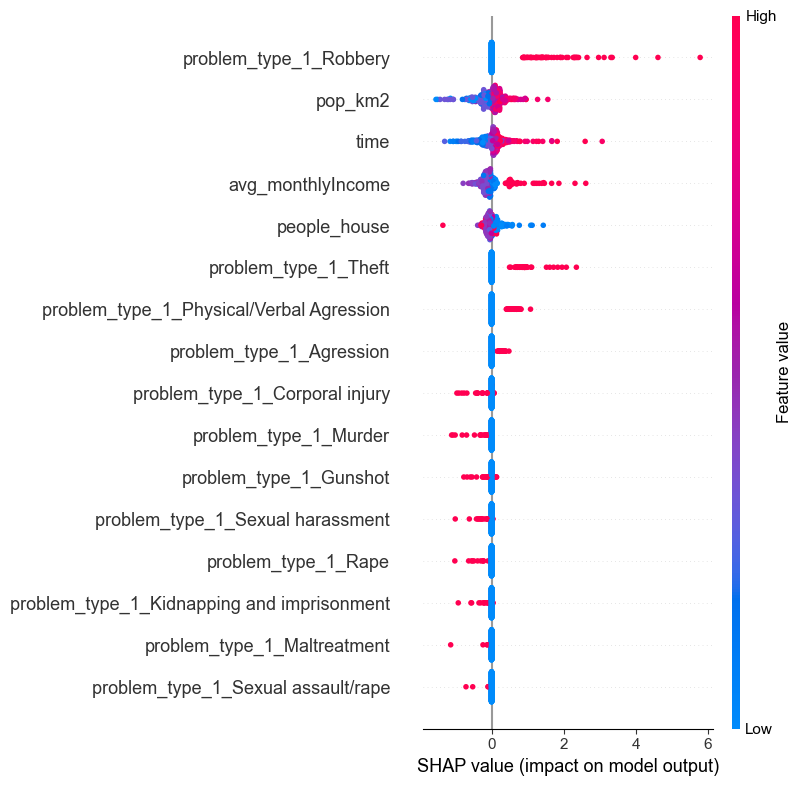

In [28]:
shap_values = ex.shap_values(X_test_pr)
shap.summary_plot(shap_values, X_test_pr)

In [39]:
print(y_test[50])
shap.force_plot(ex.expected_value, shap_values[50,:], X_test_pr.loc[50,:])


0.0275482099453888


In [41]:
X_test_pr.loc[50,:]

time                                         -0.756314
avg_monthlyIncome                             2.229914
pop_km2                                       1.058195
people_house                                 -0.982552
problem_type_1_Agression                      0.000000
problem_type_1_Corporal injury                0.000000
problem_type_1_Gunshot                        0.000000
problem_type_1_Kidnapping and imprisonment    0.000000
problem_type_1_Maltreatment                   0.000000
problem_type_1_Murder                         0.000000
problem_type_1_Physical/Verbal Agression      0.000000
problem_type_1_Rape                           0.000000
problem_type_1_Robbery                        0.000000
problem_type_1_Sexual assault/rape            1.000000
problem_type_1_Sexual harassment              0.000000
problem_type_1_Theft                          0.000000
Name: 50, dtype: float64

In [40]:
print(y_test[10])
shap.force_plot(ex.expected_value, shap_values[10,:], X_test_pr.loc[10,:])

0.6329113847646667
